### Q.1. Implement CNN(VGG16) model using Keras/Tensorflow library for Steel Defect Detection 

#### Dataset: <a>https://www.kaggle.com/c/severstal-steel-defect-detection/data</a>

#### For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Binary cross entropy loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i)Plot a comparative loss curve for at least 50 epochs 
#### (ii) Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve.

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

from PIL import Image

import tensorflow as tf 
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split 

import os 
from tqdm import * 
import pandas as pd 

data_path = "Q1_dataset/train.csv" 

In [2]:
tf.config.list_physical_devices("GPU")

2021-11-09 15:39:42.322942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:42.329274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:42.329625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
filePaths = pd.read_csv(data_path)

_image_paths = list(filePaths["ImageId"])
image_paths = [os.path.join("Q1_dataset/train_images", i) for i in tqdm(_image_paths, desc = "Loading image paths", ncols=100)]

df = filePaths
df["ImageId"] = image_paths
df.head()

Loading image paths: 100%|█████████████████████████████████| 7095/7095 [00:00<00:00, 1075482.00it/s]


,ImageId,ClassId,EncodedPixels
0,Q1_dataset/train_images/0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,Q1_dataset/train_images/0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,Q1_dataset/train_images/000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,Q1_dataset/train_images/000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,Q1_dataset/train_images/0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
EPOCHS = 50 
LR = 0.01 
BATCH_SIZE = 32 

img = cv2.imread(image_paths[0])
# (HEIGHT, WIDTH, CHANNELS) = img.shape
HEIGHT = WIDTH = 256 
CHANNELS = 1

In [5]:
class SteelDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, dim = (HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):

        self.data = df 
        self.batch_size = batch_size 
        self.idx = self.data.index.tolist()
        self.dim = dim 

        self.channels = n_channels
        self.shuffle = shuffle 
        self.min_depth = 0.1 

        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) 

    def __getitem__(self, idx):
        if (idx+1)*self.batch_size > len(self.idx):
            self.batch_size = len(self.idx) - idx*self.batch_size 

        idx = self.idx[idx*self.batch_size : (idx+1)*self.batch_size] 
        batch = [self.idx[k] for k in idx]
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        self.idx = np.arange(len(self.idx)) 
        if self.shuffle:
            np.random.shuffle(self.idx) 

    def rle2mask(self, rle, imgshape):
        w, h = imgshape
        mask = np.zeros(w*h).astype(np.uint8)

        arr = np.asarray([int(x) for x in rle.split()])
        starts = arr[0::2]
        lens = arr[1::2] 

        currPos = 0
        for idx, start in enumerate(starts):
            mask[int(start) : int(start+lens[idx])] = 1
            currPos += lens[idx] 
        return np.flipud(np.rot90(mask.reshape(h, w), k=1))


    def load_img(self, img_path):
        img = np.asarray(Image.open(img_path))/256.
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img = tf.image.convert_image_dtype(img, tf.float32)
        return img[:,:,0]


    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for idx, batch_idx in enumerate(batch):
            img = self.load_img(self.data["ImageId"][batch_idx])
            mask = self.rle2mask(self.data["EncodedPixels"][batch_idx], img.shape)
            # mask = np.expand_dims(mask, -1)
            img = np.expand_dims(cv2.resize(img, (HEIGHT, WIDTH)), -1)
            x[idx, :] = tf.image.convert_image_dtype(img, tf.float32)
            mask = np.expand_dims(cv2.resize(mask, (HEIGHT, WIDTH)), -1)
            y[idx, :] = tf.image.convert_image_dtype(mask, tf.uint8)

            # x[idx, :] = img
            # y[idx, :] = mask 

        return x, y 
        

In [6]:
def visualize(samples, n_samples, model=None):
    x, y = samples 

    if model is not None:
        fig, ax = plt.subplots(n_samples, 3, figsize = (15, 10), constrained_layout=True)
        pred = model.predict(x) 
        for i in range(n_samples):
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i, 1].imshow(y[i])
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            ax[i, 1].set_title("Ground Truth", color="white")

            ax[i, 2].imshow(pred[i])
            ax[i, 2].set_xticks([])
            ax[i, 2].set_yticks([])
            ax[i, 2].set_title("Predicted", color="white")
         

    else :
        fig, ax = plt.subplots(n_samples, 2, figsize = (20, 20), constrained_layout=True)
        for i in range(n_samples): 
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i][1].imshow(y[i])
            ax[i][1].set_xticks([])
            ax[i][1].set_yticks([])
            ax[i][1].set_title("Output", color="white")


2021-11-09 15:39:49.325544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 15:39:49.328281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:49.329268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:49.329624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

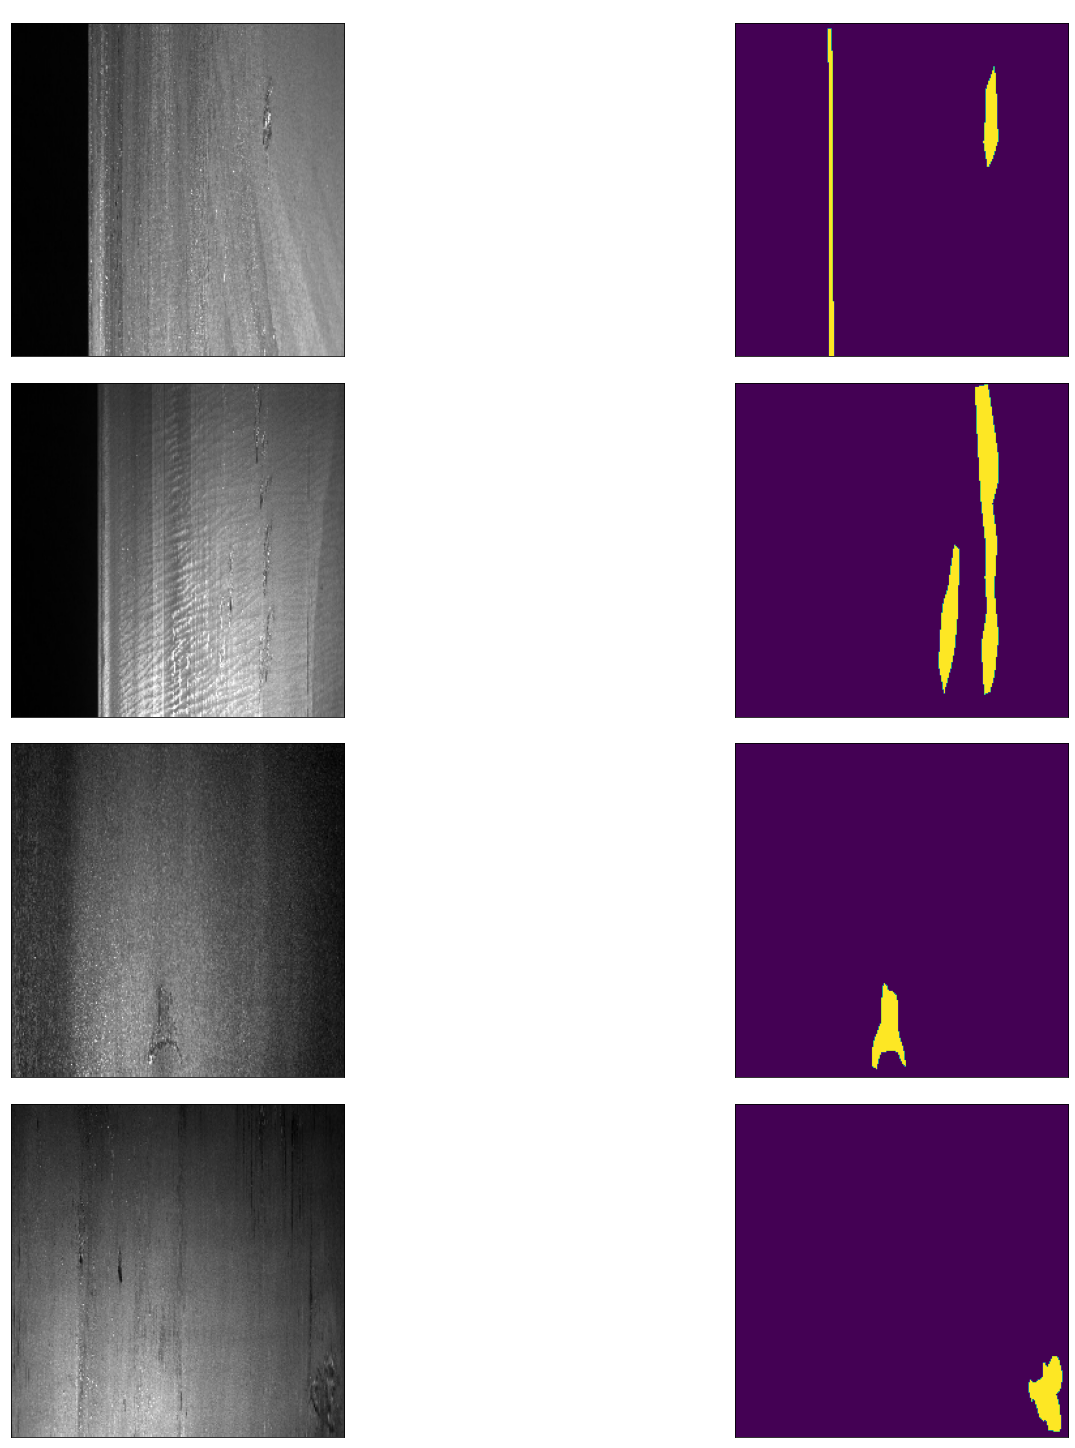

In [7]:
# Visualising generator output
trialGen = SteelDataGenerator(df = df)
v_samples = next(iter(trialGen))
visualize(v_samples, n_samples=4)

In [8]:
class ConvLayer(tf.keras.layers.Layer):
    
    def __init__(self, numKernels, kernelSize, strides, padding = "same", n_convs=3, activation = "relu", pool=True):
        super(ConvLayer, self).__init__() 
        
        self.pool = pool

        self.convLayers = models.Sequential([
            layers.Conv2D(
                numKernels, kernelSize, strides=strides, 
                padding=padding, activation=activation
            )
        ] * n_convs)

        self.pooling = layers.MaxPool2D(pool_size=(2, 2))

    def call(self, x):

        x = self.convLayers(x)
        if self.pool == True:
            x = self.pooling(x)         
        return x 


class VGGNet(tf.keras.models.Model):

    def __init__(self, n_classes=1000):
        super(VGGNet, self).__init__()

        self.conv1 = ConvLayer(numKernels=64, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv2 = ConvLayer(numKernels=128, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv3 = ConvLayer(numKernels=256, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv4 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv5 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3) 

        # self.flat = layers.Flatten()
        # self.dense = layers.Dense(n_classes, activation="relu") 

        self.upsample = layers.UpSampling2D(32, interpolation="bilinear") 
        self.convUp = layers.Conv2D(1, (1, 1), activation = "sigmoid") 


    def call(self, input_tensor):
        # downSampled = self.striding(input_tensor)

        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # x = self.flat(x)
        # x = self.dense(x)

        x = self.upsample(x)
        x = self.convUp(x)

        return x

    def build_graph(self, inShape = (HEIGHT, WIDTH, CHANNELS)):
        x = layers.Input(shape=inShape)
        return models.Model(inputs = [x], outputs = self.call(x)) 

In [9]:
vggModel = VGGNet().build_graph()
vggModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv_layer (ConvLayer)       (None, 128, 128, 64)      640       
_________________________________________________________________
conv_layer_1 (ConvLayer)     (None, 64, 64, 128)       73856     
_________________________________________________________________
conv_layer_2 (ConvLayer)     (None, 32, 32, 256)       295168    
_________________________________________________________________
conv_layer_3 (ConvLayer)     (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 8, 8, 512)         2359808   
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 512)     0     

In [10]:
lenDf = len(df)
split = int(0.8*lenDf)

X_df = df[:split]
Y_df = df[split:] 

trainGen = SteelDataGenerator(df = X_df)
valGen = SteelDataGenerator(df = Y_df)

vggModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

vggHist = vggModel.fit(trainGen, epochs=50, validation_data=valGen)

2021-11-09 15:39:56.456560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-09 15:40:01.590958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
2021-11-09 15:40:03.859011: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-09 15:40:04.122842: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-09 15:40:04.122905: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-09 15:40:04.424767: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.1

ResourceExhaustedError:  OOM when allocating tensor with shape[32,256,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/up_sampling2d/resize/ResizeBilinear (defined at tmp/ipykernel_88336/3854607943.py:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1351]

Errors may have originated from an input operation.
Input Source operations connected to node model/up_sampling2d/resize/ResizeBilinear:
 model/conv_layer_4/max_pooling2d_4/MaxPool (defined at tmp/ipykernel_88336/2695067331.py:21)

Function call stack:
train_function
